<a href="https://colab.research.google.com/github/praveentn/MidcurveNN/blob/master/cnn_encdec/notebook_cnn_autoencoder_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN ENC-DEC

In [5]:
# mount google drive & set working directory
# requires auth (click on url & copy token into text box when prompted)
from google.colab import drive
drive.mount("/content/gdrive")

import os
print(os.getcwd())

os.chdir('/content/gdrive/My Drive/Colab Notebooks/MidcurveNN')
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/MidcurveNN
/content/gdrive/My Drive/Colab Notebooks/MidcurveNN


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import os
import sys
import PIL
import json
import time

from keras.layers import Input, Dense, Dropout
from keras import regularizers, optimizers
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, UpSampling2D, Reshape, Flatten
from keras.layers import GlobalMaxPooling2D, AveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from random import shuffle

import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
from IPython.display import clear_output

import matplotlib
# matplotlib.use('TKAgg')
%matplotlib inline

In [7]:
# working directory
wdir = os.getcwd()
wdir

'/content/gdrive/My Drive/Colab Notebooks/MidcurveNN'

In [8]:
# _URL = 'https://drive.google.com/uc?export=download&id=16rqDFLO__WySSQGlAht0FEj2uJZg4M9M'

# path_to_zip = tf.keras.utils.get_file('input.zip',
#                                       origin=_URL,
#                                       extract=True)

# input_data_folder = os.path.join(os.path.dirname(path_to_zip), 'input')
input_data_folder = wdir + "/data/input"
input_data_folder = wdir + "/data/images"
print("input data dir: ", input_data_folder)

input data dir:  /content/gdrive/My Drive/Colab Notebooks/MidcurveNN/data/images


In [9]:
import glob

image_paths = glob.glob(input_data_folder + '/**/*.png', recursive=True)
images = [os.path.basename(img_path) for img_path in image_paths]

print(len(images))

#images = os.listdir(input_data_folder)
images[99]

5376


'CapI_Midcurve_mirrored_0_translated_10_-20.png'

In [0]:
# image dimension
imdim = 100

In [0]:
def read_input_image_pairs(datafolder=input_data_folder):
    profile_pngs = []
    midcurve_pngs = []
    for file in os.listdir(datafolder):
        fullpath = os.path.join(datafolder, file)
        if os.path.isdir(fullpath):
            continue
        if file.endswith(".png"):
            if file.find("Profile") != -1:
                profile_pngs.append(fullpath)
            if file.find("Midcurve") != -1:
                midcurve_pngs.append(fullpath)
    profile_pngs = sorted(profile_pngs)
    midcurve_pngs = sorted(midcurve_pngs)
    return profile_pngs,midcurve_pngs

In [0]:
def get_training_data(datafolder=input_data_folder):
    profile_pngs,midcurve_pngs = read_input_image_pairs(datafolder)
    
    profile_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(imdim, imdim))) for f in profile_pngs ]
    midcurve_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(imdim, imdim))) for f in midcurve_pngs]

#     profile_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in profile_pngs_objs])
#     midcurve_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in midcurve_pngs_objs])

    profile_pngs_gray_objs = [x[:,:,3] for x in profile_pngs_objs]
    midcurve_pngs_gray_objs =[x[:,:,3] for x in midcurve_pngs_objs]
    
#     profile_pngs_gray_objs = [np.where(x>128, 0, 1) for x in profile_pngs_gray_objs]
#     midcurve_pngs_gray_objs =[np.where(x>128, 0, 1) for x in midcurve_pngs_gray_objs]
        
    # shufle them
    zipped_profiles_midcurves = [(p,m) for p,m in zip(profile_pngs_gray_objs,midcurve_pngs_gray_objs)]
    shuffle(zipped_profiles_midcurves)
    profile_pngs_gray_objs, midcurve_pngs_gray_objs = zip(*zipped_profiles_midcurves)
    
    return profile_pngs_gray_objs, midcurve_pngs_gray_objs

In [13]:
shapes = os.listdir('/content/gdrive/My Drive/Colab Notebooks/MidcurveNN/data/images')
shapes

['CapI',
 'Iuvw',
 'Tuvw',
 'Vuvw',
 'Sm_n',
 'InvV',
 'Parl',
 'Trap',
 'Stik',
 'Usla',
 'LapT',
 'RelY',
 'T002',
 'T003',
 'T004',
 'T005',
 'Plus',
 'SqLu',
 'Luvw',
 'L001',
 'L002',
 'L003',
 'T006',
 'X001']

In [14]:
profile_pngs_objs = ()
midcurve_pngs_objs = ()

for shape in shapes:
    print(shape)
    tp, tm = get_training_data(os.path.join(input_data_folder, shape))
    profile_pngs_objs += tp
    midcurve_pngs_objs += tm
    print(len(profile_pngs_objs), len(midcurve_pngs_objs))

CapI
112 112
Iuvw
224 224
Tuvw
336 336
Vuvw
448 448
Sm_n
560 560
InvV
672 672
Parl
784 784
Trap
896 896
Stik
1008 1008
Usla
1120 1120
LapT
1232 1232
RelY
1344 1344
T002
1456 1456
T003
1568 1568
T004
1680 1680
T005
1792 1792
Plus
1904 1904
SqLu
2016 2016
Luvw
2128 2128
L001
2240 2240
L002
2352 2352
L003
2464 2464
T006
2576 2576
X001
2688 2688


In [15]:
len(profile_pngs_objs)

2688

In [16]:
profile_pngs_objs[0].shape

(100, 100)

In [17]:
type(midcurve_pngs_objs)

tuple

In [0]:
def plot_results(original_imgs,computed_imgs,n=10):
    # n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(imdim, imdim),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(computed_imgs[i].reshape(imdim, imdim),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

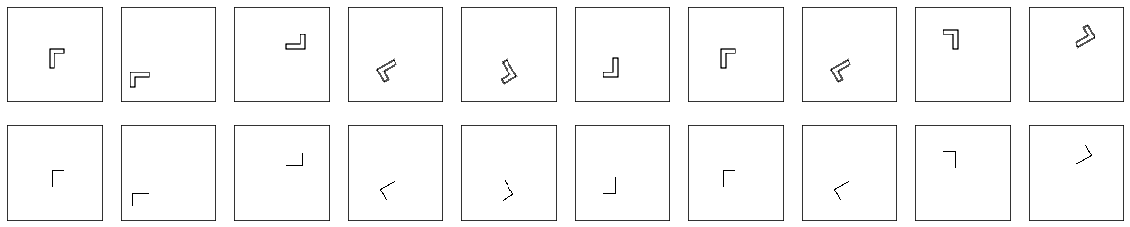

In [20]:
plot_results(profile_pngs_objs[2030:2050],midcurve_pngs_objs[2030:2050])

In [0]:
def get_train_test_split(profile_pngs_gray_objs, midcurve_pngs_gray_objs, encoding_dim=imdim, input_dim=imdim):

    # Training
    profile_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in profile_pngs_gray_objs]
    midcurve_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in midcurve_pngs_gray_objs]
    
    profile_pngs_objs = np.array(profile_pngs_flat_objs)
    midcurve_pngs_objs= np.array(midcurve_pngs_flat_objs)
    
    '''
    train_size = int(len(profile_pngs_objs)*0.7)
    x_train = profile_pngs_objs[:train_size]
    y_train = midcurve_pngs_objs[:train_size]
    x_test = profile_pngs_objs[train_size:]
    y_test = midcurve_pngs_objs[train_size:]
    '''
    x_train, x_test, y_train, y_test = train_test_split(profile_pngs_objs, midcurve_pngs_objs, 
                                                        test_size=0.2, random_state=23)
    return x_train, x_test, y_train, y_test

In [22]:
x_train, x_test, y_train, y_test = get_train_test_split(profile_pngs_objs, midcurve_pngs_objs)

print((len(x_train), len(y_train)), (len(x_test), len(y_test)))

(2150, 2150) (538, 538)


### Auto-encoder

In [0]:
class Autoencoder():
    def __init__(self):
        self.img_rows = imdim
        self.img_cols = imdim
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        adam_optimizer = Adam(lr=0.0005)
        optimizer = SGD(lr=0.0001, nesterov=False)
        
        self.autoencoder_model = self.build_model()
        #self.autoencoder_model.compile(loss='mean_squared_error', optimizer=RMSprop())
        #self.autoencoder_model.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.autoencoder_model.compile(loss='mse', metrics=['accuracy'], optimizer=adam_optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        '''
        # encoder
        x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer) # 28 x 28 x 32
        x = MaxPooling2D(pool_size=(2,2))(x) # 14 x 14 x 32
        x = Conv2D(64, (3,3), activation='relu', padding='same')(x)# 14 x 14 x 64
        x = MaxPooling2D(pool_size=(2,2))(x) # 7 x 7 x 64
        x = Conv2D(128, (3,3), activation='relu', padding='same')(x) # 7 x 7 x 128

        # decoder
        x = Conv2D(128, (3,3), activation='relu', padding='same')(x) # 7 x 7 x 128
        x = UpSampling2D((2,2))(x) # 14 x 14 x 128
        x = Conv2D(64, (3,3), activation='relu', padding='same')(x)# 14 x 14 x 64
        x = UpSampling2D((2,2))(x) # 28 x 28 x 64
        output_layer = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x) # 28 x 28 x 1
        '''
        
        # encoder
        x = Conv2D(8, (3,3), activation='relu', padding='same')(input_layer)
        x = MaxPooling2D(pool_size=(2,2))(x) # 14 x 14 x 32
        #x = GlobalMaxPooling2D()(x) # 14 x 14 x 32
        x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(2,2))(x) # 7 x 7 x 64
        #x = GlobalMaxPooling2D()(x) # 7 x 7 x 64
        x = Conv2D(32, (3,3), activation='relu', padding='same')(x)

        # decoder
        x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
        x = UpSampling2D((2,2))(x) # 14 x 14 x 128
        x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
        x = UpSampling2D((2,2))(x) # 28 x 28 x 64
        #output_layer = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
        output_layer = Conv2D(1, (3,3), activation='relu', padding='same')(x)
        
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=100):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 100, 100, 8)       80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 25, 25, 32)        9248      
__________

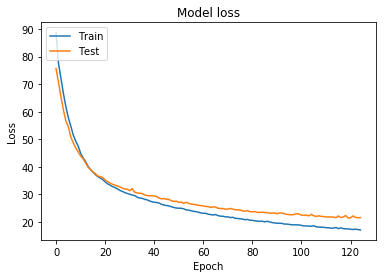

In [43]:
'''
x_train_reshaped = x_train
x_test_reshaped = x_test


noise_factor = 0.01 
x_train_noisy = x_train_reshaped + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_reshaped.shape) 
x_test_noisy = x_test_reshaped + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_reshaped.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
'''

ae = Autoencoder()
#ae.train_model(x_train_noisy, y_train, x_test_noisy, y_test, epochs=50, batch_size=32)
ae.train_model(x_train, y_train, x_test, y_test, epochs=200, batch_size=100)

#encoded_imgs = ae.eval_model(x_test)
#decoded_imgs = ae.eval_model(encoded_imgs)

#plot_results(x_test, decoded_imgs)

Number of samples to evaluate:  10
Samples to evaluate:  [ 33 263 322 292 285 123 373 395 488 158]


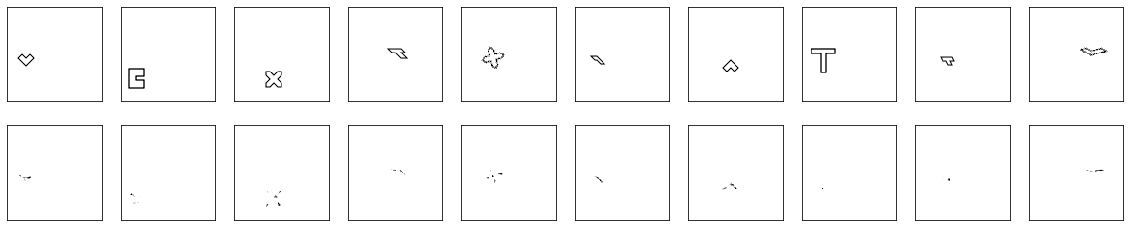

In [45]:
# evaluation

n = 10  # for 10 random indices
index = np.random.choice(x_test.shape[0], n, replace=False)

x_eval = x_test[index]
print("Number of samples to evaluate: ", len(x_eval))
print("Samples to evaluate: ", index)

#encoded_imgs = ae.eval_model(x_test)
encoded_imgs = ae.eval_model(x_eval)
decoded_imgs = ae.eval_model(encoded_imgs)

plot_results(x_eval, decoded_imgs)